In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

---

In [ ]:
train_df = pd.read_csv('data-dataset/preprocessed_train.csv')
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Companion,AgeWeight,FareWeight,...,AgeGroup_Adult,AgeGroup_Child,AgeGroup_Elder,AgeGroup_Little,AgeGroup_Young,FareCategory_Budget,FareCategory_Economy,FareCategory_Luxuary,FareCategory_Premium,FareCategory_Standard
0,0.0,3,1,22.0,1,0,7.2500,1,66.0,2.416667,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1,0,38.0,1,0,66.3438,1,38.0,66.343800,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3,0,26.0,0,0,7.9250,0,78.0,2.641667,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1,0,35.0,1,0,53.1000,1,35.0,53.100000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,3,1,35.0,0,0,8.0500,0,105.0,2.683333,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Survived               891 non-null    float64
 1   Pclass                 891 non-null    int64  
 2   Sex                    891 non-null    int64  
 3   Age                    891 non-null    float64
 4   SibSp                  891 non-null    int64  
 5   Parch                  891 non-null    int64  
 6   Fare                   891 non-null    float64
 7   Companion              891 non-null    int64  
 8   AgeWeight              891 non-null    float64
 9   FareWeight             891 non-null    float64
 10  Title_Master           891 non-null    float64
 11  Title_Miss             891 non-null    float64
 12  Title_Mr               891 non-null    float64
 13  Title_Mrs              891 non-null    float64
 14  Ticket_1               891 non-null    float64
 15  Ticket

---

In [6]:
X = train_df.drop(columns='Survived')
y = train_df['Survived']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

**I'll use Logistic Regression just to see the classification report and confusion matrix in general**

In [ ]:
trial_model = make_pipeline(StandardScaler(), LogisticRegression())
trial_model.fit(X_train, y_train)
y_pred = trial_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       110
         1.0       0.82      0.68      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



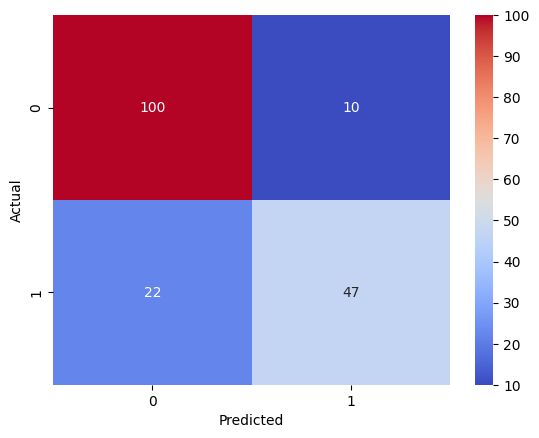

In [9]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The dataset is unbalanced, there are more non-survivors than survivors. So i'm going to balance the dataset with SMOTE and see the results

In [ ]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [ ]:
trial_model = make_pipeline(StandardScaler(), LogisticRegression())
trial_model.fit(X_train_balanced, y_train_balanced)
y_pred = trial_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       110
         1.0       0.78      0.71      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



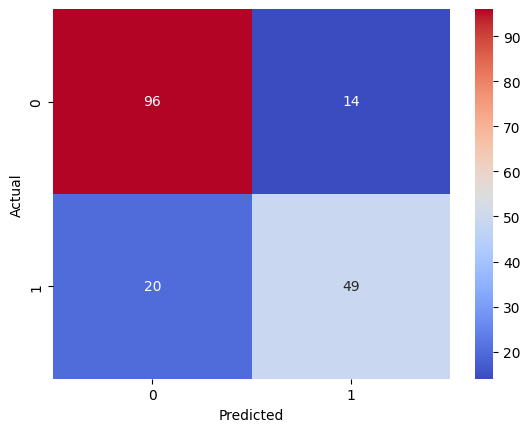

In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

4 non-survivors were predicted wrong, but 2 survivors were predicted right, there wasn't much change balancing the dataset. I'm going to choose the best model and then see the results with and without SMOTE again

**Choosing the best model according to F1-Score with Cross Validation in the whole train.csv**

In [13]:
models_list = [
     {'Decision Tree': DecisionTreeClassifier()},
     {'Random Forest': RandomForestClassifier()},
     {'Ada Boost': AdaBoostClassifier(algorithm='SAMME')}, # I needed to put a parameter because of errors
     {'Gradient Boosting': GradientBoostingClassifier()},
     {'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))}, # I needed to put a parameter because of errors
     {'SVC': SVC()},
     {'KNeighbors': KNeighborsClassifier()},
     {'GaussianNB': GaussianNB()},
     {'XGBoost': xgb.XGBClassifier()}
]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [ ]:
scores_list = []
for models in models_list:
    for model_name, model in models.items():
        cv_score = cross_val_score(model, X, y, cv=skf, scoring='f1')
        scores_list.append({model_name: round(cv_score.mean(), 3)})
sorted(scores_list, key=lambda x: list(x.values())[0], reverse=True)

[{'Gradient Boosting': 0.779},
 {'Logistic Regression': 0.768},
 {'Random Forest': 0.764},
 {'XGBoost': 0.757},
 {'Ada Boost': 0.756},
 {'GaussianNB': 0.747},
 {'Decision Tree': 0.716},
 {'KNeighbors': 0.579},
 {'SVC': 0.544}]

---
# **Gradient Boosting**

In [ ]:
model = GradientBoostingClassifier()

In [17]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7518796992481203

In [18]:
cv_score = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
round(cv_score.mean(), 3)

0.756

In [19]:
cv_score = cross_val_score(model, X, y, cv=skf, scoring='f1')
round(cv_score.mean(), 3)

0.777

---
**RFECV**


In [20]:
X_train.shape

(712, 57)

In [ ]:
rfecv = RFECV(estimator=model, cv=skf, scoring='f1', step=1)

In [65]:
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingClassifier(random_state=42), scoring='f1')

In [67]:
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)
X_selected = rfecv.transform(X)

In [68]:
X_train_selected.shape

(712, 3)

In [69]:
X.columns[rfecv.support_]

Index(['Pclass', 'FareWeight', 'Title_Mr'], dtype='object')

In [70]:
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
f1_score(y_test, y_pred)

0.7883211678832117

In [71]:
cv_score = cross_val_score(model, X_train_selected, y_train, cv=skf, scoring='f1')
round(cv_score.mean(), 3)

0.781

In [72]:
cv_score = cross_val_score(model, X_selected, y, cv=skf, scoring='f1')
round(cv_score.mean(), 3)

0.788

In [73]:
joblib.dump(rfecv, 'feature_selection.joblib')

['feature_selection.joblib']

---
**SMOTE**

In [ ]:
smote = SMOTE()
X_train_selected_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

In [76]:
model.fit(X_train_selected_balanced, y_train_balanced)
y_pred = model.predict(X_test_selected)
f1_score(y_test, y_pred)

0.7536231884057971

The f1_score is worse with SMOTE, so I won't balance the dataset

---
**RandomizedSearchCV**

In [ ]:
randomized_params = {
    'learning_rate': [0.01, 0.05, 0.10, 0.50],
    'n_estimators': list(range(50, 1001, 50)),
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': list(range(2, 11, 1)),
    'min_samples_leaf': list(range(1, 11, 1)),
    'max_depth': [None] + list(range(5, 51, 5)),
    'max_features': ['sqrt', 'log2', None],
}

In [ ]:
randomized_search = RandomizedSearchCV(estimator=model, param_distributions=randomized_params, cv=skf, scoring='f1', verbose=3, n_iter=500)
randomized_search.fit(X_selected, y)

In [83]:
randomized_results = pd.DataFrame(randomized_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
randomized_results.iloc[:5,4:]

,param_subsample,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
427,0.1,750,6,1,sqrt,10,0.01,"{'subsample': 0.1, 'n_estimators': 750, 'min_s...",0.812030,0.794118,0.803279,0.809160,0.805970,0.804911,0.006149,1
59,0.7,200,2,2,sqrt,25,0.01,"{'subsample': 0.7, 'n_estimators': 200, 'min_s...",0.809160,0.808824,0.793388,0.793893,0.796875,0.800428,0.007094,2
206,0.6,500,2,6,None,40,0.01,"{'subsample': 0.6, 'n_estimators': 500, 'min_s...",0.815385,0.800000,0.783333,0.791045,0.812030,0.800359,0.012155,3
135,0.6,200,4,2,None,15,0.01,"{'subsample': 0.6, 'n_estimators': 200, 'min_s...",0.809160,0.808824,0.793388,0.781955,0.806202,0.799906,0.010673,4
210,0.2,700,2,8,log2,40,0.05,"{'subsample': 0.2, 'n_estimators': 700, 'min_s...",0.839695,0.770370,0.773109,0.796992,0.818182,0.799670,0.026517,5


In [87]:
randomized_search.best_params_

{'subsample': 0.1,
 'n_estimators': 750,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'learning_rate': 0.01}

---
**GridSearchCV**

In [99]:
grid_params = {
    'subsample': [0.1, 0.2],
    'n_estimators': [725, 750, 775],
    'min_samples_split':[5, 6, 7],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01],
}

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=grid_params, cv=skf, scoring='f1', verbose=3)
grid_search.fit(X_selected, y)

In [101]:
grid_results = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
grid_results.iloc[:5,4:]

,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.01,5,sqrt,1,5,750,0.1,"{'learning_rate': 0.01, 'max_depth': 5, 'max_f...",0.828125,0.805970,0.784000,0.81203,0.81203,0.808431,0.014260,1
80,0.01,15,sqrt,1,6,750,0.1,"{'learning_rate': 0.01, 'max_depth': 15, 'max_...",0.818182,0.794118,0.803279,0.80916,0.80597,0.806142,0.007834,2
44,0.01,10,sqrt,1,6,750,0.1,"{'learning_rate': 0.01, 'max_depth': 10, 'max_...",0.812030,0.794118,0.803279,0.80916,0.80597,0.804911,0.006149,3
46,0.01,10,sqrt,1,6,775,0.1,"{'learning_rate': 0.01, 'max_depth': 10, 'max_...",0.812030,0.794118,0.803279,0.80597,0.80597,0.804273,0.005832,4
84,0.01,15,sqrt,1,7,725,0.1,"{'learning_rate': 0.01, 'max_depth': 15, 'max_...",0.818182,0.791045,0.793388,0.80303,0.81203,0.803535,0.010449,5


In [102]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 750,
 'subsample': 0.1}

---

In [103]:
best_model = grid_search.best_estimator_

In [104]:
y_pred = best_model.predict(X_test_selected)
f1_score(y_test, y_pred)

0.8181818181818182

In [106]:
cv_score = cross_val_score(best_model, X_train_selected, y_train, cv=skf, scoring='f1')
round(cv_score.mean(), 10)

0.7648619712

In [108]:
cv_score = cross_val_score(best_model, X_selected, y, cv=skf, scoring='f1')
round(cv_score.mean(), 10)

0.8084310599

In [110]:
joblib.dump(best_model, 'titanic_model.joblib')

['titanic_model.joblib']

---
# **Prediction**

In [111]:
titanic_model = joblib.load('titanic_model.joblib')
feature_selection = joblib.load('feature_selection.joblib')

In [ ]:
test_df = pd.read_csv('data/preprocessed_test.csv')
test_df = test_df.drop(columns='Survived')
test_df = feature_selection.transform(test_df)
test_df.shape

(418, 3)

In [ ]:
predictions = titanic_model.predict(test_df)
ids = np.arange(892, 1310)

In [119]:
df_predictions = pd.DataFrame({
    'PassengerId': ids.astype(int),
    'Survived': predictions.astype(int)
})
df_predictions

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [121]:
df_predictions.to_csv('titanic_submission.csv', index=False)